In [1]:
from sklearn.metrics import ndcg_score, average_precision_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def baseline_ranker(q, x):
    '''where q is a query and x is a df with "bow" bag of words col set as cocatenation of title/snippet/doc'''
    us = x[(x['for_query']==q) & (x['country']=='us')]
    ru = x[(x['for_query']==q) & (x['country']=='ru')]
    idx_scores = []
    print('for query:', q)
    for i,row in us.iterrows():
        toks = ' '.join(row['bow']).split(' ') #(' '.join(row['title_en']) +  ' '.join(row['snippet_en']) + ' '.join(row['doc_en'])).split(' ') 
        tok_bucket = ' '.join(ru['bow']).split(' ') #(' '.join(ru['title_en']) +  ' '.join(ru['snippet_en']) + ' '.join(ru['doc_en'])).split(' ') 
        no_overlap = set(toks) - set(tok_bucket)
        idx_scores.append((row['index'], 'us', row['title_en'][:25],(len(no_overlap) / len(toks)) * 5))

    for i,row in ru.iterrows():
        toks = ' '.join(row['bow']).split(' ') #(' '.join(row['title_en']) +  ' '.join(row['snippet_en']) + ' '.join(row['doc_en'])).split(' ') 
        tok_bucket = ' '.join(us['bow']).split(' ')#(' '.join(us['title_en']) +  ' '.join(us['snippet_en']) + ' '.join(us['doc_en'])).split(' ') 
        no_overlap = set(toks) - set(tok_bucket)
        idx_scores.append((row['index'], 'ru',row['title_en'][:25], (len(no_overlap) / len(toks)) * 5))

    return sorted(idx_scores, key=lambda x: x[3], reverse=True)

In [25]:
# load in annotated df
ann_df = pd.read_csv('bag_of_words_translated - temp for figs.csv')
ann_df['index'] = ann_df.index
ann_df['bow'] = ann_df.title_en.astype(str) + ann_df.snippet_en.astype(str)  +ann_df.doc_en.astype(str) 
queries_ann = set(ann_df['for_query'])

In [26]:
# load in full dataset
ann_df[['title_en','bow']]

,title_en,bow
0,Atomic Heart – Atomic Heart,Atomic Heart – Atomic Heartnan#VALUE!
1,Atomic Heart on Steam,Atomic Heart on SteamnanWelcome to Steam\t\t\t...
2,Atomic Heart | Exclusively on VK Play,Atomic Heart | Exclusively on VK PlaynanAtomic...
3,Atomic Heart,Atomic HeartnanWikipedia the free encyclopedia...
4,Atomic Heart,Atomic HeartAtomic Heart (from English - “Atom...
...,...,...
401,"Biography of Inna Churikova - RIA Novosti, 01/...","Biography of Inna Churikova - RIA Novosti, 01/..."
402,"Inna Churikova - biography, personal life, pho...","Inna Churikova - biography, personal life, pho..."
403,The star of the changeable era: like Inna Chur...,The star of the changeable era: like Inna Chur...
404,Inna Churikova Inna Churikova,Inna Churikova Inna ChurikovaInna Churikova In...


In [27]:
x = ann_df.copy()
full_idx_scores = []
for q in queries_ann:
    full_idx_scores += baseline_ranker(q,x)

for query: аватар 2
for query: госуслуги
for query: вайлдберриз
for query: вконтакте
for query: вк
for query: chatgpt
for query: инна чурикова
for query: валберис
for query: гипсофилы
for query: авито
for query: дневник ру
for query: днс
for query: гдз
for query: atomic heart
for query: youtube


In [28]:
discdf = pd.DataFrame().from_records(full_idx_scores, columns=['index','country','bow','discordance'])

In [30]:
base_rec = []
for q in queries_ann:
    # baseline DOES NOT ACTUALLY USE DISC SCORES FROM ANN DF
    baseline = baseline_ranker(q, ann_df)
    truth = ann_df[ann_df['for_query']==q]['discordance'] # when 3 or above
    truth = sorted(truth, reverse=True)
    mp = average_precision_score([1 if t > 2 else 0 for t in truth ], [1 if b[3] > 2 else 0 for b in baseline ])

    ng = ndcg_score(np.asarray([truth]), np.asarray([[b[3] for b in baseline]]) )
    base_rec.append([q, 'map',mp])
    base_rec.append([q, 'ndcg',ng])

basedf = pd.DataFrame().from_records(base_rec, columns=['query','score','value'])

for query: аватар 2
for query: госуслуги
for query: вайлдберриз
for query: вконтакте
for query: вк
for query: chatgpt
for query: инна чурикова
for query: валберис
for query: гипсофилы
for query: авито


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


for query: дневник ру
for query: днс
for query: гдз


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


for query: atomic heart
for query: youtube


[Text(0.5, 1.0, 'MAP and NDCG Scores for Discordance Baseline')]

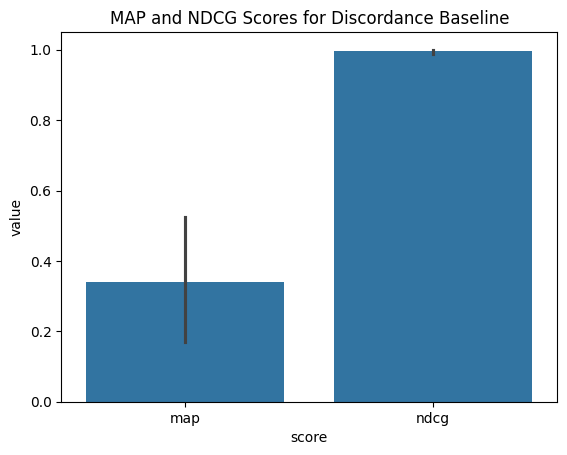

In [31]:
sns.barplot(basedf, x='score',y='value').set(title='MAP and NDCG Scores for Discordance Baseline')

[Text(0.5, 1.0, 'MAP and NDCG Scores for Discordance Baseline - Annotated Subset')]

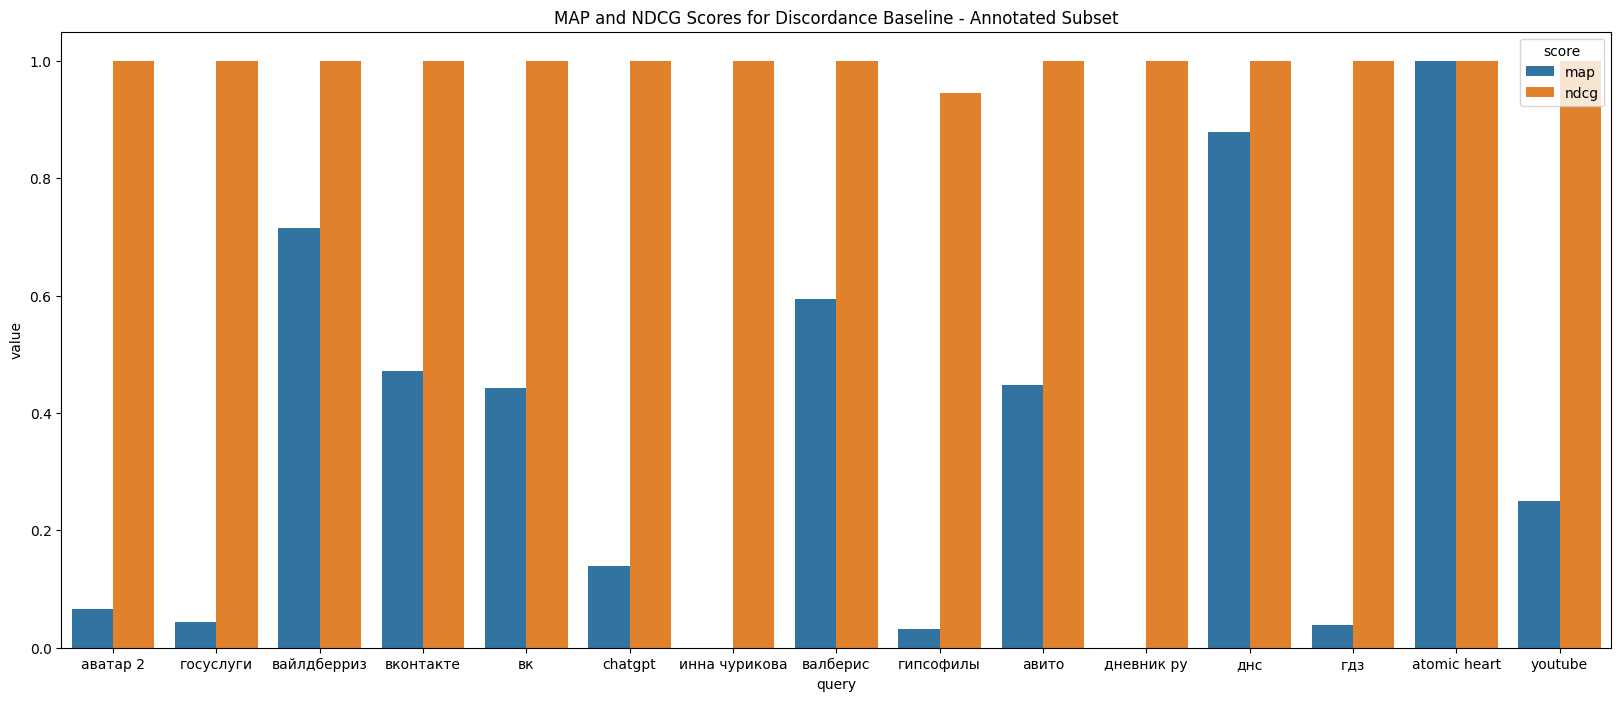

In [32]:
plt.figure(figsize=(20,8))
sns.barplot(basedf, x='query',hue='score', y='value').set(title='MAP and NDCG Scores for Discordance Baseline - Annotated Subset',)

[Text(0.5, 1.0, 'Annotated Discordance ECDF')]

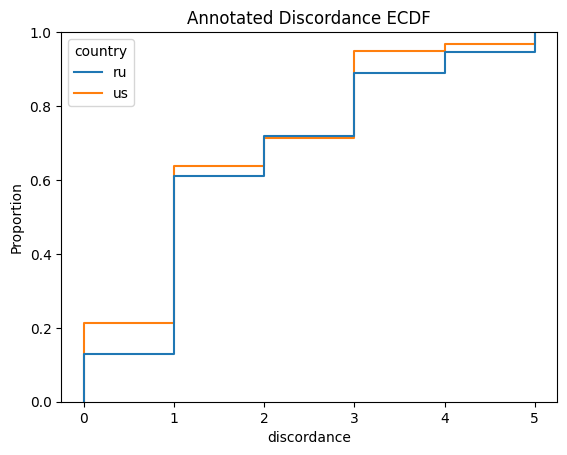

In [33]:
sns.ecdfplot(ann_df, x='discordance',hue='country').set(title='Annotated Discordance ECDF')

[Text(0.5, 1.0, 'Baseline Discordance ECDF'), (0.0, 5.0)]

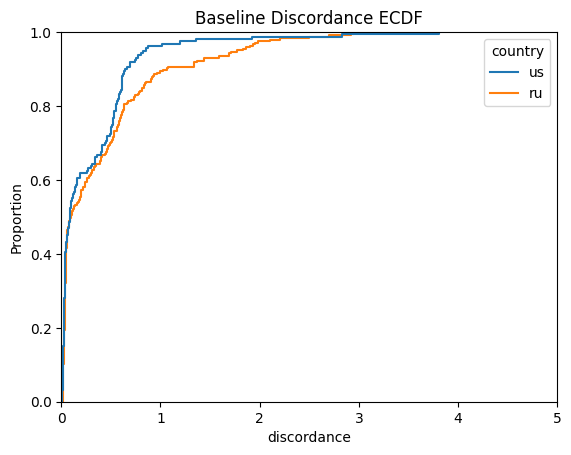

In [34]:
sns.ecdfplot(discdf, x='discordance',hue='country').set(title='Baseline Discordance ECDF', xlim=(0,5))